# Ex 2: Manipulating Spectra Part 1 - `Spectrum`

## Notebook Initialization

In [1]:
%load_ext autoreload
import sys
sys.path.append("..")

In [2]:
%matplotlib inline

/usr/local/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:280: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  import matplotlib


In [3]:
%autoreload


import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

import numpy as np
from scipy.integrate import quad

import darkhistory.physics as phys
import darkhistory.spec.spectools as spectools
from darkhistory.spec.spectrum import Spectrum

## DarkHistory Binning

DarkHistory deals extensively with spectra, so it is important to understand how we generally deal with the problem of discretizing spectra in our code. 

Here are some general rules followed in DarkHistory when dealing with spectra: 

1. Spectra in DarkHistory should be viewed as a series of bins indexed by energies $E_i$, each containing some number of particles at that energy. 


2. Each bin has a *log bin width* ($\Delta \log E$), and two *bin boundaries*. We always use log-binning for all of the bins, with the bin boundaries taken to be the midpoint in log-space between two bin energies. The first and last bins are assumed to have their energies at the center of the bin in log-space. 


3. Consider a spectrum $dN/dE$ that is a function of the energy $E$. There are several ways in which we discretize this spectrum over some chosen energy abscissa $E_i$ (a vector of energy values over which we want to approximate the function):

    a. The first is to simply assign the value of $dN/dE$ to each bin:
    
    $$ \frac{dN}{dE} (E_i) \approx \mathbf{S}[E_i] $$ 
    
    where $\mathbf{S}$ is some vector of entries. This method is fast, but may fail to capture sharp features if the binning is insufficiently fine. 

    b. The second method is implemented numerically in [*spectools.discretize()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectools/darkhistory.spec.spectools.discretize.html). Given an abscissa $E_i$, total number and energy conservation is enforced, and a good approximation to the spectrum is returned. See the linked documentation for more details.

## `Spectrum` Class - Introduction

Individual spectra are stored as [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) objects in DarkHistory. 

The main attributes are as follows: 

1. `eng`: the energy abscissa of the spectrum. 
2. `N` and `dNdE`: the number of particles in each bin, or the $dN/dE$ in each bin. 

The relationship between `N` and `dNdE` is given by `Spectrum.N == Spectrum.dNdE * Spectrum.eng * log_bin_width`. To calculate `log_bin_width`, the function [*spectools.get_log_bin_width()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectools/darkhistory.spec.spectools.get_log_bin_width.html) can be used with `spec.eng` as the argument. 

Other optional attributes include `rs` and `in_eng`, which contain the redshift or the injected energy of the particle that produced the spectrum, if these attributes are applicable. 

To initialize, simply define an abscissa, a spectrum over that abscissa, and then do the following:

In [4]:
# Create the energy abscissa. 
eng = 10**((np.arange(120)-90)*(1/10))

# Random spectrum
random_spec_arr = 1e14/(np.exp((eng - 0.1)/0.1) + 1)

random_spec = Spectrum(eng, random_spec_arr, spec_type = 'dNdE')

<ipython-input-4-d0be96f568d9>:5: RuntimeWarning: overflow encountered in exp
  random_spec_arr = 1e14/(np.exp((eng - 0.1)/0.1) + 1)


`spec_type = 'dNdE'` tells the constructor that you are giving it an array of $dN/dE$ values. Let's make a plot of this spectrum:

(1e-08, 10000.0, 1e-10, 1e+20)

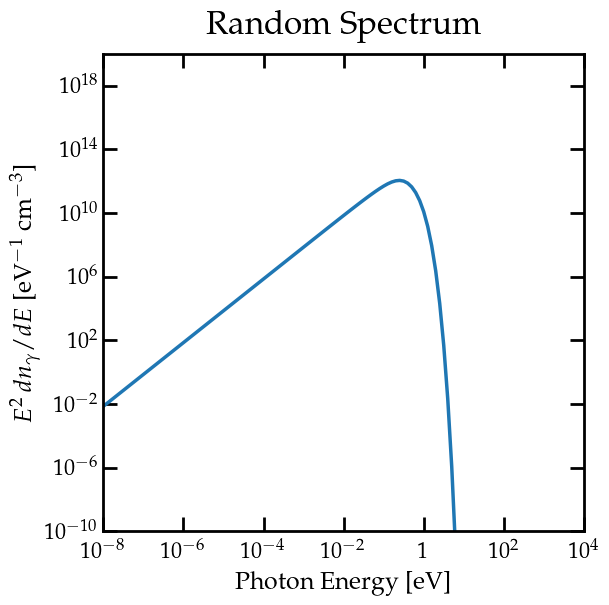

In [5]:
plt.figure()

plt.loglog()

random_plot, = plt.plot(
    random_spec.eng, random_spec.eng**2*random_spec.dNdE
)

plt.title(r'Random Spectrum')
plt.xlabel('Photon Energy [eV]')
plt.ylabel('$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-10, 1e20])

## The CMB Spectrum

To create our first [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html), we will use the function [*spectools.discretize()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectools/darkhistory.spec.spectools.discretize.html), and apply it to the CMB blackbody spectrum,

$$ \frac{dn_\gamma}{dE} = \frac{E^2}{\pi^2 (\hbar c)^3} \frac{1}{e^{E/T_\text{CMB}} - 1}$$

The function [*physics.CMB_spec()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/physics/darkhistory.physics.CMB_spec.html) returns the value of $dn_\gamma/dE$ for some photon energy $E$ and temperature $T$. This function can be passed to [*spectools.discretize()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectools/darkhistory.spec.spectools.discretize.html) to create a [*Spectrum*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html) object. 

In [6]:
T = 1.5 # The temperature in eV of the CMB.

# discretize() takes the abscissa, the function to discretize, and
# any other arguments that need to be passed to the function. 
discrete_CMB = spectools.discretize(eng, phys.CMB_spec, T)

We should also set the `rs` attribute to the correct redshift. Here, we use [*physics.TCMB()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/physics/darkhistory.physics.TCMB.html), which takes in a redshift as an argument, to calculate what the redshift $1+z$ is at the temperature `T` that we selected earlier. 

In [7]:
rs = T/phys.TCMB(1)

discrete_CMB.rs = rs

Let's plot the spectrum contained in `discrete_CMB` as a check, and make sure that it agrees with [*physics.CMB_spec()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/physics/darkhistory.physics.CMB_spec.html). 

(1e-08, 10000.0, 1e-10, 1e+20)

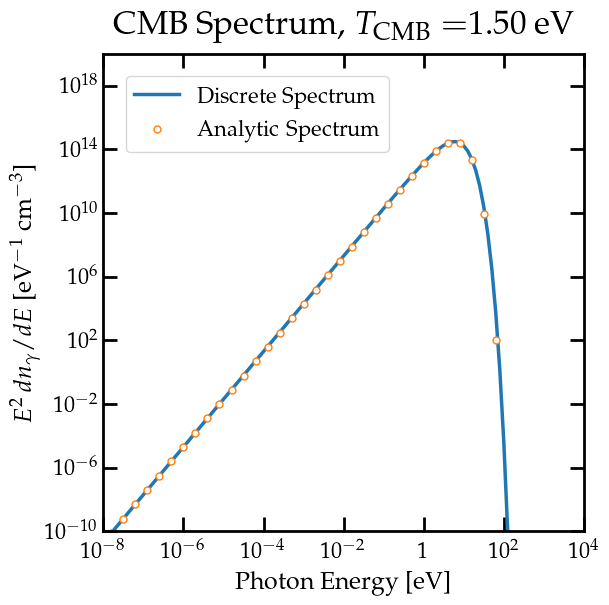

In [8]:
plt.figure()

plt.loglog()

discrete_plot, = plt.plot(
    discrete_CMB.eng, discrete_CMB.eng**2*discrete_CMB.dNdE, label='Discrete Spectrum'
)
analytic_plot, = plt.plot(
    eng, eng**2*phys.CMB_spec(eng, T), 'o', marker='o', markersize='5', 
    markevery=3, markerfacecolor='w', label='Analytic Spectrum'
)

plt.legend(handles=[discrete_plot, analytic_plot])

plt.title(r'CMB Spectrum, $T_\mathrm{CMB} = $'+'{:3.2f}'.format(T)+' eV')
plt.xlabel('Photon Energy [eV]')
plt.ylabel('$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-10, 1e20])

## Number and Energy

At this point, let's introduce two important methods for the `Spectrum` class: [*Spectrum.totN()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html?highlight=Spectrum#darkhistory.spec.spectrum.Spectrum.totN) and [*Spectrum.toteng()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html?highlight=Spectrum#darkhistory.spec.spectrum.Spectrum.toteng). These methods are used to obtain the total number of particles and total energy stored in the `Spectrum` object respectively. One can find the total amount of energy stored between two abscissa values or in a certain bin using this method, but for now we'll simply use them to find the total number of particles and total energy in the spectrum. 

Analytically, the total number density of particles in a blackbody at temperature $T$ is

$$ n_\gamma = \frac{16 \pi \zeta(3)}{\hbar^3 c^3} T^3 $$

and the total energy density is

$$ u_\gamma = \frac{\pi^2}{15 c^3 \hbar^3} T^4 $$

where $T$ is expressed in eV. Let's check that we do recover these results in `discrete_CMB`. The physical constants can all be found in [*physics*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/darkhistory.physics.html). 

In [9]:
from scipy.special import zeta

n_gamma_analytic = 16*np.pi*zeta(3)/(phys.hbar**3 * phys.c**3 * (2*np.pi)**3) * T**3
u_gamma_analytic = np.pi**2/(15 * phys.c**3 * phys.hbar**3) * T**4

print('Number density (Analytic): ', n_gamma_analytic)
print('Total number of photons in discrete_spec: ', discrete_CMB.totN())
print('Ratio: ', discrete_CMB.totN()/n_gamma_analytic)
print('Energy density (Analytic): ', u_gamma_analytic)
print('Total energy of photons in discrete_spec: ', discrete_CMB.toteng())
print('Ratio: ', discrete_CMB.toteng()/u_gamma_analytic)


Number density (Analytic):  106996520624887.58
Total number of photons in discrete_spec:  106996520624887.56
Ratio:  0.9999999999999999
Energy density (Analytic):  433524976666076.75
Total energy of photons in discrete_spec:  433524976666076.9
Ratio:  1.0000000000000002


Because we used `spectools.discretize`, the total number and energy density enforced by the analytic expression for $dn_\gamma/dE$ are fully preserved. Of course, the energy abscissa provided must span the part of the spectrum that contains the bulk of the energy. 

For convenience, the expression `n_gamma_analytic` and `u_gamma_analytic` can be obtained using [*phys.CMB_N_density()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/physics/darkhistory.physics.CMB_N_density.html) and [*phys.CMB_eng_density()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/physics/darkhistory.physics.CMB_eng_density.html) respectively. 

`self.totN()` can also be used to find the total number of particles in various bins or combinations of bins. This is done by specifying the bin boundaries for the sets of desired combinations using the bound_arr keyword; e.g. `bound_arr=[a,b,c,d]` will produce three outputs, corresponding to the total number of particles in the bins between boundaries a-b, between boundaries b-c, and between boundaries c-d. For example, the code below returns the total number of particles in each of the first two bins. The bin boundaries do not need to be integers.

In [10]:
print('Number of particles in first and second bin: ',
      discrete_CMB.totN(bound_type='bin', bound_arr=np.array([0,1,2]))
     )

Number of particles in first and second bin:  [2.78182594e-06 7.41174243e-06]


One can also use `Spectrum.N` to get a list of number of particles in each bin. This is related to the `Spectrum` type, which we will come back to later.

In [11]:
print('Number of particles in first and second bin: ', discrete_CMB.N[0:2])

Number of particles in first and second bin:  [2.78182594e-06 7.41174243e-06]


`self.totN()` can also return the total number of particles between different energy boundaries: 

In [12]:
print('Number of particles between 0.2 and 0.45 eV, 0.45 eV and 0.6 eV: ', 
      discrete_CMB.totN(bound_type='eng', bound_arr=np.array([0.2, 0.45, 0.6]))
     )

Number of particles between 0.2 and 0.45 eV, 0.45 eV and 0.6 eV:  [1.45086071e+12 1.37229631e+12]


The function `self.toteng()` can be used in a similar manner. 

## Addition and Multiplication

You can add or subtract two `Spectrum` objects together (they must have the same `eng` and `spec_type` to do so), or add or subtract a scalar to a `Spectrum`.

(1e-08, 10000.0, 1e-10, 1e+20)

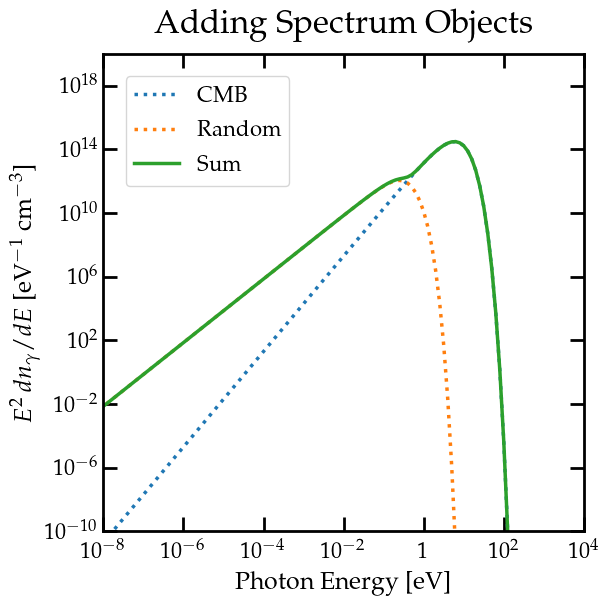

In [13]:
sum_of_BB_spec = discrete_CMB + random_spec

plt.figure()

plt.loglog()

CMB_plot, = plt.plot(discrete_CMB.eng, discrete_CMB.eng**2*discrete_CMB.dNdE, ':', label='CMB')
random_plot, = plt.plot(random_spec.eng, random_spec.eng**2*random_spec.dNdE, ':', label='Random')
sum_plot, = plt.plot(sum_of_BB_spec.eng, sum_of_BB_spec.eng**2*sum_of_BB_spec.dNdE, label='Sum')

plt.legend(handles=[CMB_plot, random_plot, sum_plot])

plt.title(r'Adding Spectrum Objects')
plt.xlabel('Photon Energy [eV]')
plt.ylabel('$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-10, 1e20])

Similarly, you can multiply or divide `Spectrum` objects by another `Spectrum`, an array or a scalar. Suppose, for example, we wanted to find the average energy of particles in `discrete_CMB`. We could do

In [14]:
a = discrete_CMB * discrete_CMB.eng

print('Mean energy in the CMB at {:3.2f}'.format(T)+' eV in units of k_B T: ', np.sum(a.N)/discrete_CMB.totN()/T)

Mean energy in the CMB at 1.50 eV in units of k_B T:  2.701178032919065


which should be close to the theoretical value of $\langle E \rangle \approx 2.70 k_B T$. Of course, we could simply have done

In [15]:
print(
    'Mean energy in the CMB at {:3.2f}'.format(T)+' eV in units of k_B T: ', 
    discrete_CMB.toteng()/discrete_CMB.totN()/T
)

Mean energy in the CMB at 1.50 eV in units of k_B T:  2.701178032919065


## `Spectrum` - Rebinning

Changing the abscissa of a spectrum is frequently useful, for example in redshifting a spectrum, or in converting a spectrum of photoionizing photons into a spectrum of electrons freed from an atom. DarkHistory provides the method [*Spectrum.rebin()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html?highlight=Spectrum.rebin#darkhistory.spec.spectrum.Spectrum.rebin) for doing so in a manner that conserves total number and total energy, while attempting to preserve the shape of the spectrum. 

To see how this works, let's perform redshifting on our CMB spectrum. Let's first create a copy of `discrete_CMB`, called `redshifted_CMB`. 

In [16]:
redshifted_CMB = Spectrum(discrete_CMB.eng, discrete_CMB.dNdE, spec_type='dNdE', rs=discrete_CMB.rs)

The first thing we'll do is to change the energy abscissa of `redshifted_CMB` to the final energy after redshifting to `final_rs`. This is done by the function [*Spectrum.shift_eng()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html?highlight=Spectrum.rebin#darkhistory.spec.spectrum.Spectrum.shift_eng), which not only changes the abscissa, but ensures that $dN/dE$ is correctly updated with the new bin widths. The argument passed to Spectrum.shift_eng() is the array of shifted energy abscissae.

In [17]:
final_rs = rs/4

redshifted_CMB.shift_eng(discrete_CMB.eng * final_rs / rs)

At this point, the energy abscissa has been changed, but it is often the case that we want the final spectrum to have the same binning as the original. To do this, we use the function [*Spectrum.rebin()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html?highlight=Spectrum.rebin#darkhistory.spec.spectrum.Spectrum.rebin), which reassigns the particles in each bin of the original spectrum to the new one in a manner that conserves *total* number and energy, while attempting to preserve the spectral shape. The argument passed to Spectrum.rebin() is the array of desired new energy abscissae.

In [18]:
redshifted_CMB.rebin(discrete_CMB.eng)

Let's make a plot for comparison! Don't forget that since we're actually storing number *densities* in these spectra, to compare before and after redshifting, we also have to include a factor of redshift$^3$. 

(1e-08, 10000.0, 1e-10, 1e+26)

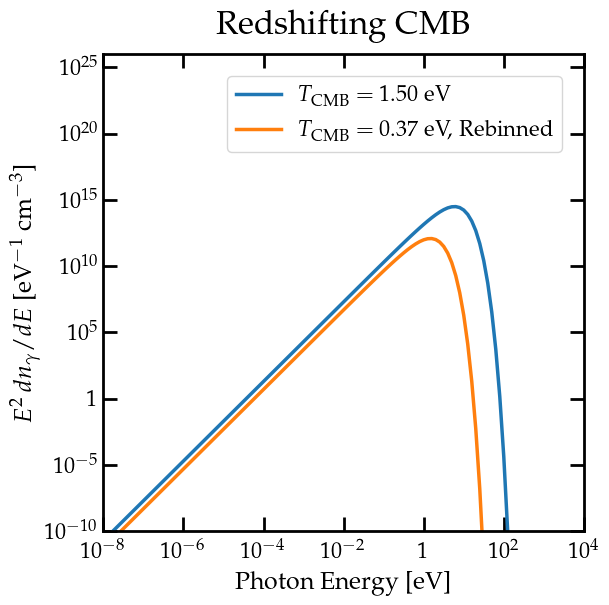

In [19]:
plt.figure()

plt.loglog()

orig_plot, = plt.plot(discrete_CMB.eng, 
                      discrete_CMB.dNdE*discrete_CMB.eng**2, 
                      label=r'$T_\mathrm{CMB} =$ '+'{:3.2f}'.format(T)+' eV')
redshifted_plot, = plt.plot(redshifted_CMB.eng, 
                          redshifted_CMB.eng**2*redshifted_CMB.dNdE * (final_rs/rs)**3, 
                          label=r'$T_\mathrm{CMB} =$ '+'{:3.2f}'.format(T * final_rs/rs)+' eV, Rebinned')


plt.legend(handles=[orig_plot, redshifted_plot])

plt.title('Redshifting CMB')
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-10, 1e26])


Redshifting is also provided as a convenience function, [*Spectrum.redshift()*](https://darkhistory.readthedocs.io/en/latest/_autosummary/darkhistory/spec/spectrum/darkhistory.spec.spectrum.Spectrum.html?highlight=Spectrum.rebin#darkhistory.spec.spectrum.Spectrum.redshift). The input to Spectrum.redshift() is the new desired redshift (1+z), and the effect of calling the function is to update the Spectrum object to the desired redshift, properly redshifting the stored spectrum while maintaining the original energy abscissa.

## Underflow

Let's perform a really large redshift on yet another copy of `discrete_CMB`: 

In [20]:
large_redshift_CMB = Spectrum(discrete_CMB.eng, discrete_CMB.N, spec_type='N', rs=discrete_CMB.rs)

final_rs_large = rs/1e8

large_redshift_CMB.redshift(final_rs_large)

This spectrum looks like this:

(1e-08, 10000.0, 1e-30, 1e+28)

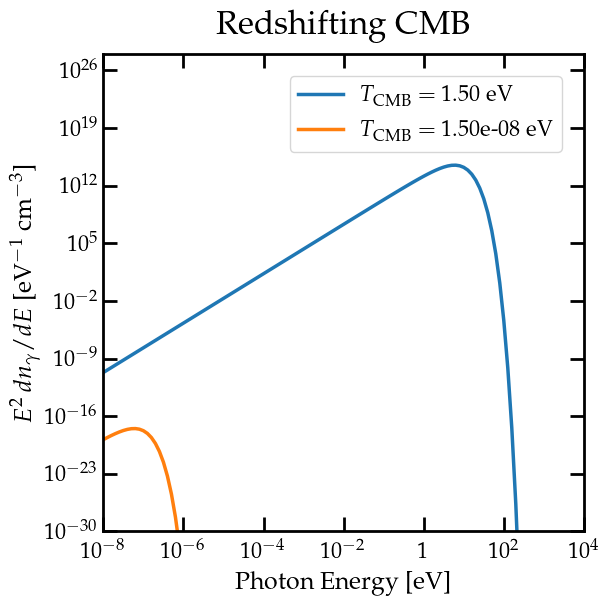

In [21]:
plt.figure()

plt.loglog()

orig_spec, = plt.plot(discrete_CMB.eng, 
                      discrete_CMB.dNdE*discrete_CMB.eng**2, 
                      label=r'$T_\mathrm{CMB} =$ '+'{:3.2f}'.format(T)+' eV')
large_redshift_spec, = plt.plot(large_redshift_CMB.eng, 
                          large_redshift_CMB.dNdE*discrete_CMB.eng**2*(final_rs_large/rs)**3, 
                          label=r'$T_\mathrm{CMB} =$ '+'{:2.2e}'.format(T * (final_rs_large/rs))+' eV')


plt.legend(handles=[orig_spec, large_redshift_spec])

plt.title('Redshifting CMB')
plt.xlabel('Photon Energy [eV]')
plt.ylabel(r'$E^2 \, dn_\gamma/dE$ [eV$^{-1}$ cm$^{-3}$]')
plt.axis([1e-8, 1e4, 1e-30, 1e28])

Because the spectrum has shifted so significantly to low energies, the photons that were in the lowest energy bins of `discrete_CMB` are in danger of being lost. However, number and energy conservation is always enforced when using `Spectrum.rebin()` or any function that calls this method, e.g. `Spectrum.redshift()` by assigning photons below the new energy abscissa to an underflow bin. `Spectrum.totN()` and `Spectrum.toteng()` automatically include these underflow photons. 

In [22]:
print('Original total number of particles: ', discrete_CMB.totN())
print('Redshifted total number of particles: ', large_redshift_CMB.totN())
print('Total number of photons in underflow: ', large_redshift_CMB.underflow['N'])
print('Ratio: ', discrete_CMB.totN()/large_redshift_CMB.totN())
print('**********************************************************')
print('Original total energy: ', discrete_CMB.toteng())
print('Redshifted total energy: ', large_redshift_CMB.toteng())
print('Ratio: ', discrete_CMB.toteng()/large_redshift_CMB.toteng())
print('Total energy of photons in underflow: ', large_redshift_CMB.underflow['eng'])


Original total number of particles:  106996520624887.56
Redshifted total number of particles:  106996520624887.56
Total number of photons in underflow:  78358875758.77504
Ratio:  1.0
**********************************************************
Original total energy:  433524976666076.9
Redshifted total energy:  4335249.766660767
Ratio:  100000000.00000004
Total energy of photons in underflow:  45.937555674926635
